## 1. EDA

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 42

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.3


In [2]:
import pandas as pd

df = pd.read_csv("bayesdata.csv")

In [3]:
df.head()

,player_id,game_id,date,points,3_pointers,rebounds,assists,steals,blocks,turnovers,double_double,triple_double,dfs_points
0,1630173,22300432,"DEC 29, 2023",0,0,2,0,0,0,0,0,0,2.50
1,1630173,22300416,"DEC 27, 2023",3,0,1,0,1,1,1,0,0,7.75
2,1630173,22300395,"DEC 23, 2023",8,0,2,1,0,2,0,0,0,16.00
3,1630173,22300382,"DEC 22, 2023",4,0,6,1,2,0,1,0,0,16.50
4,1630173,22300369,"DEC 20, 2023",13,1,5,1,1,1,1,0,0,24.75


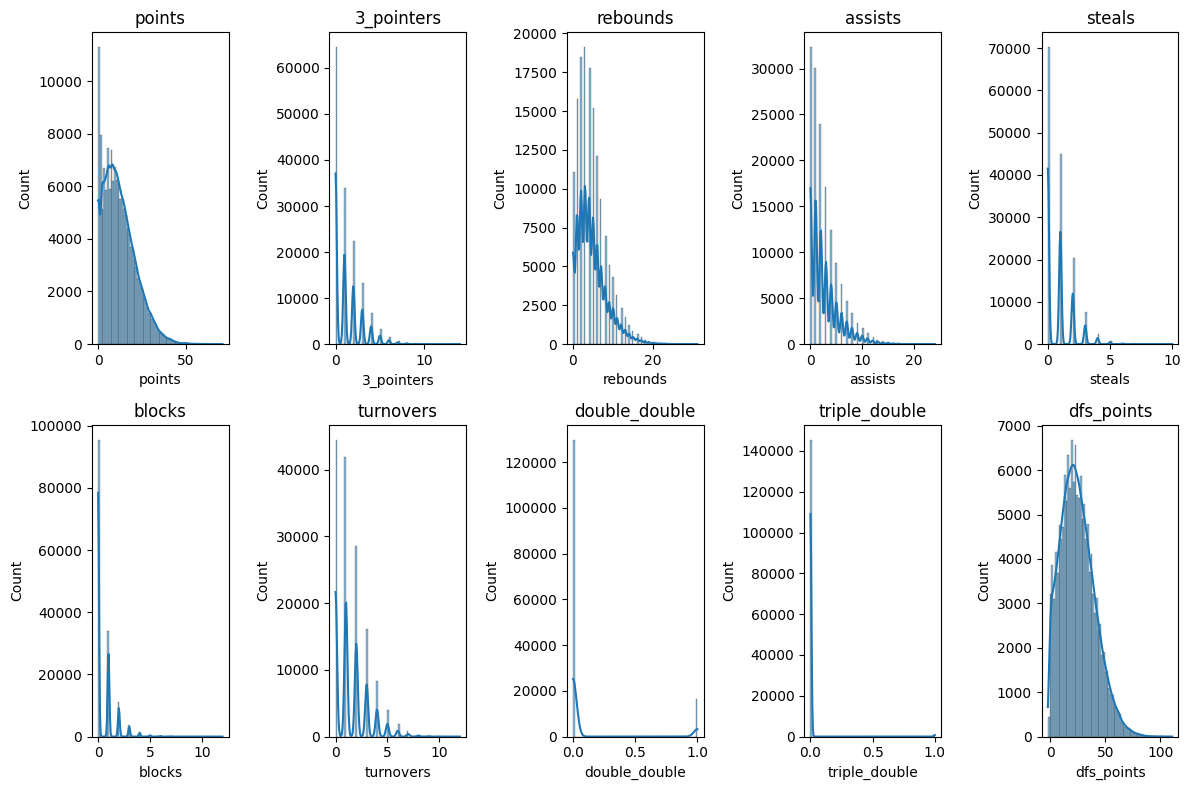

In [4]:
columns = [
    "points",
    "3_pointers",
    "rebounds",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "double_double",
    "triple_double",
    "dfs_points"
    
]

# Set up a 2x4 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))

# Flatten the 2D array of subplots to a 1D array
axes = axes.flatten()

# Iterate through columns and create histograms
for i, column in enumerate(columns):
    sns.histplot(x=df[column], bins=70, ax=axes[i], kde=True)
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

## 1.1 - IMPORTANT - Check specs of the data

Make sure that the data you assume is positive is in fact all positive!!

In [50]:
for column in columns:
    print()
    print(str(column))
    print("min:", df[column].min())
    print("max:", df[column].max())
    print("avg:", df[column].mean())


points
min: 0
max: 71
avg: 12.391810430164051

3_pointers
min: 0
max: 14
avg: 1.2163927935062364

rebounds
min: 0
max: 31
avg: 4.717645532806751

assists
min: 0
max: 24
avg: 2.7323711931403136

steals
min: 0
max: 10
avg: 0.84234600181596

blocks
min: 0
max: 12
avg: 0.5282736774554714

turnovers
min: 0
max: 12
avg: 1.5071989841547253

double_double
min: 0
max: 1
avg: 0.11357942094088573

triple_double
min: 0
max: 1
avg: 0.00677912874883089

dfs_points
min: -2.0
max: 110.75
avg: 25.173966916759397


### 1.1.1. Add modified columns if needed (e.g. min(0,x) columns)

In [52]:
df["abs_dfs"] = df["dfs_points"].apply(lambda x: max(0, x))
print("min:", df["abs_dfs"].min())
print("max:", df["abs_dfs"].max())
print("avg:", df["abs_dfs"].mean())

min: 0.0
max: 110.75
avg: 25.175728261389004


## 1.2. Write down model shape

https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/generalized_linear_models/GLM-poisson-regression.html 

"points",
"3_pointers",
"rebounds",
"assists",
"steals",
"blocks",
"turnovers",
"double_double",
"triple_double",
"dfs_points"


y_dfs = poisson, observed = data['dfs_points']

mu = a * points * 1 + b * 3_pts * 0.5, c * rebounds * ..., d * assists, e * steals, f * blocks, g * turnovers, h * double, i * triple

a, b, c,d,e,f, g = poisson, shape= num players
all above hyperpriors (x_mu) = gamma with find_constrained_priors

lower, upper for (most of density should be between):
a_mu: 0.05, 50
b_mu: 0.05, 10
c_mu: 0.05, 20
d_mu: 0.05, 18
e_mu: 0.05, 5
f_mu: 0.05, 5
g_mu: 0.05, 8


set b init_guess for all to 1
a guesses for:
a_mu: 15
b_mu: 4
c_mu: 7
d_mu: 5
e_mu: 3
f_mu: 2
g_mu: 3

a_mu = gamma, pre-set find_constrained_priors

h, i = binomial, shape = num players



#### 1.5.1 Make super simple model

y_dfs = poisson, observed = dfs_points

mu = gamma, shape=numplayers

mu_a = normal, (0.05, 75) - 40, 20

mu_b = normal, (0, 10) - 1

## 2. Create The Models

### 2.1. Make labels

In [5]:
player_labels = df["player_id"].astype("category").cat.codes.values
df["player_labels"] = df["player_id"].astype("category").cat.codes.values
df.head(5)

,player_id,game_id,date,points,3_pointers,rebounds,assists,steals,blocks,turnovers,double_double,triple_double,dfs_points,player_labels
0,1630173,22300432,"DEC 29, 2023",0,0,2,0,0,0,0,0,0,2.50,290
1,1630173,22300416,"DEC 27, 2023",3,0,1,0,1,1,1,0,0,7.75,290
2,1630173,22300395,"DEC 23, 2023",8,0,2,1,0,2,0,0,0,16.00,290
3,1630173,22300382,"DEC 22, 2023",4,0,6,1,2,0,1,0,0,16.50,290
4,1630173,22300369,"DEC 20, 2023",13,1,5,1,1,1,1,0,0,24.75,290


### 2.2. Make hyperparameters

In [48]:
print(df.dfs_points.max())

110.75


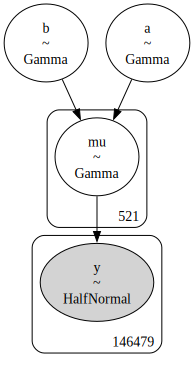

In [64]:
"""y_dfs = poisson, observed = dfs_points

mu = gamma, shape=numplayers

mu_a = normal, (0.05, 75) - 40, 20

mu_b = normal, (0, 10) - 1"""

"""find_good_alpha = pm.find_constrained_prior(
        pm.Normal,
        lower=0.5,
        upper=75,
        init_guess={"mu": 40, "sigma": 20},
    )
    alpha = pm.Normal("alpha", **find_good_alpha)

    find_good_beta = pm.find_constrained_prior(
        pm.Normal,
        lower=0.5,
        upper=10,
        init_guess={"mu": 1, "sigma": 0.5},
    )
    beta = pm.Normal("beta", **find_good_beta)
    
    with pm.Model() as simple_dfs_model:
    alpha = pm.HalfNormal("mya", sigma=10)
    beta = pm.HalfNormal("myb", sigma=10)

    mu = pm.Gamma("mymu", alpha=alpha, beta=beta, shape=len(df.player_id.unique())) + 10000

    y = pm.HalfNormal("myy", sigma=mu[player_labels], observed=df.abs_dfs)
    
    """

with pm.Model() as simple_dfs_model:
    alpha = pm.Gamma("a", alpha=50, beta=1)
    beta = pm.Gamma("b", alpha=1, beta=1)

    mu = pm.Gamma("mu", alpha=alpha, beta=beta, shape=len(df.player_id.unique()))

    y = pm.HalfNormal("y", sigma=mu[player_labels], observed=df.abs_dfs)

pm.model_to_graphviz(simple_dfs_model)

Sampling: [a, b, mu, y]


done sampling!


c:\Users\dfmil\NBADataScraper\.venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


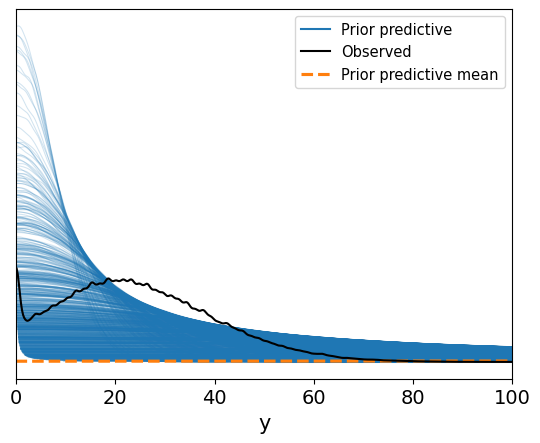

In [65]:
with simple_dfs_model:
    simple_dfs_trace = pm.sample_prior_predictive(1000)
print("done sampling!")
fig, ax = plt.subplots()

# Set the x-axis range
ax.set_xlim(0, 100)
az.plot_ppc(simple_dfs_trace, group="prior", ax=ax)
plt.show()

In [66]:
#start = {
#    "alpha_log__": np.array(1),
#    "beta_log__": np.array(1),
#    "mu_log__": np.array(np.full(len(df.player_id.unique()), 1)),
#}

with simple_dfs_model:
    new_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, mu]


In [63]:
simple_dfs_model.debug(verbose=True)

point={'a_log__': array(3.91202301), 'b_log__': array(0.), 'mu_log__': array([3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.91202301,
       3.91202301, 3.91202301, 3.91202301, 3.91202301, 3.9

This function will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from a normal distribution specified by the values of mu and std in that sample.

ppc = pm.sample_ppc(trace, samples=500, model=model, size=100)

Now, ppc contains 500 generated data sets (containing 100 samples each), each using a different parameter setting from the posterior:


np.asarray(ppc['n']).shape

(500, 100)



In [ ]:
# TODO: Plot ppc vs real data